In [25]:
from pandas_datareader import data as web
from pandas_datareader._utils import RemoteDataError
from datetime import date
import pandas as pd
import sys
import yfinance as yf
yf.pdr_override()

In [26]:
while True:
    try:
        # user interaction
        # ask for initial capital and ticker
        start_capital = float(input("Enter your initial capital:\n"))
        # ask for testing range and convert to date objects
        date_entry = input('Enter begin of testing range in YYYY-MM-DD format:\n')
        year1, month1, day1 = map(int, date_entry.split('-'))
        start_date = date(year1, month1, day1)
        ticker1 = input("Enter your first ticker available at finance.yahoo.com:\n")
        # data import: read and parse file containing OHLC data into dataframe using pandas datareader
        # strftime is used to convert from datetime to string in specific format wanted by datareader
        data1 = web.DataReader(str(ticker1),
                                   start=start_date.strftime('%Y-%m-%d'),
                                   end=str(date.today()))
       
        break
    # error handling for wrong ticker input
    except RemoteDataError:
        print("Error. No information for ticker '{}'. Only enter tickers available on Yahoo Finance.".format(ticker1))
    # error handling for wrong date/starting capital input
    except ValueError:
        print("Error. Enter correct dates and numeric start capital.")

while True:
    try:
        # Use the same structure for the second tickers 
        ticker2 = input("Enter your second ticker available at finance.yahoo.com:\n")
        data2 = web.DataReader(str(ticker2),
                                   start=start_date.strftime('%Y-%m-%d'),
                                   end=str(date.today()))
                                   
        break
    except RemoteDataError:
        print("Error. No information for your second ticker '{}'. Only enter tickers available on Yahoo Finance.".format(ticker2))

while True:
    try:
        # Use the same structure for the third ticker
        ticker3 = input("Enter your third ticker available at finance.yahoo.com:\n")
        data3 = web.DataReader(str(ticker3),
                                   start=start_date.strftime('%Y-%m-%d'),
                                   end=str(date.today()))
                                   
        break
    except RemoteDataError:
        print("Error. No information for your third ticker '{}'. Only enter tickers available on Yahoo Finance.".format(ticker3))

while True:
    try:
        # Use the same strucutre for the fourth ticker
        ticker4 = input("Enter your fourth ticker available at finance.yahoo.com:\n")
        data4 = web.DataReader(str(ticker4),
                                   start=start_date.strftime('%Y-%m-%d'),
                                   end=str(date.today()))
        break
    except RemoteDataError:
        print("Error. No information for your fourth ticker '{}'. Only enter tickers available on Yahoo Finance.".format(ticker4))

Enter your initial capital:
 2000
Enter begin of testing range in YYYY-MM-DD format:
 2018-12-12
Enter your first ticker available at finance.yahoo.com:
 meta


[*********************100%***********************]  1 of 1 completed


Enter your second ticker available at finance.yahoo.com:
 cat


[*********************100%***********************]  1 of 1 completed


Enter your third ticker available at finance.yahoo.com:
 amzn


[*********************100%***********************]  1 of 1 completed


Enter your fourth ticker available at finance.yahoo.com:
 goog


[*********************100%***********************]  1 of 1 completed


In [27]:
stocks = pd.concat([data1['Close'],data2['Close'],data3['Close'],data4['Close']],axis=1)
stocks.columns = [ticker1,ticker2,ticker3,ticker4]

In [28]:
raw_returns = (stocks-stocks.shift(1))/stocks.shift(1)

In [29]:
import numpy as np
logReturns = np.log(1+raw_returns)

In [30]:
numberPortfolios = 10000

weight = np.zeros((numberPortfolios,4))
expectedLogReturn = np.zeros(numberPortfolios)
expectedVol = np.zeros(numberPortfolios)
sharpeRatio = np.zeros(numberPortfolios)

meanLogReturn = logReturns.mean()
sigma = logReturns.cov()
for k in range(numberPortfolios):
    w = np.array(np.random.random(4))
    w = w/np.sum(w)
    weight[k,:] = w
    expectedLogReturn[k]= np.sum(meanLogReturn*w)
    expectedVol[k] = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    sharpeRatio[k] = expectedLogReturn[k]/expectedVol[k]

In [31]:
maxIndex = sharpeRatio.argmax()
weight[maxIndex,:]

array([0.00528479, 0.59045268, 0.0048056 , 0.39945693])

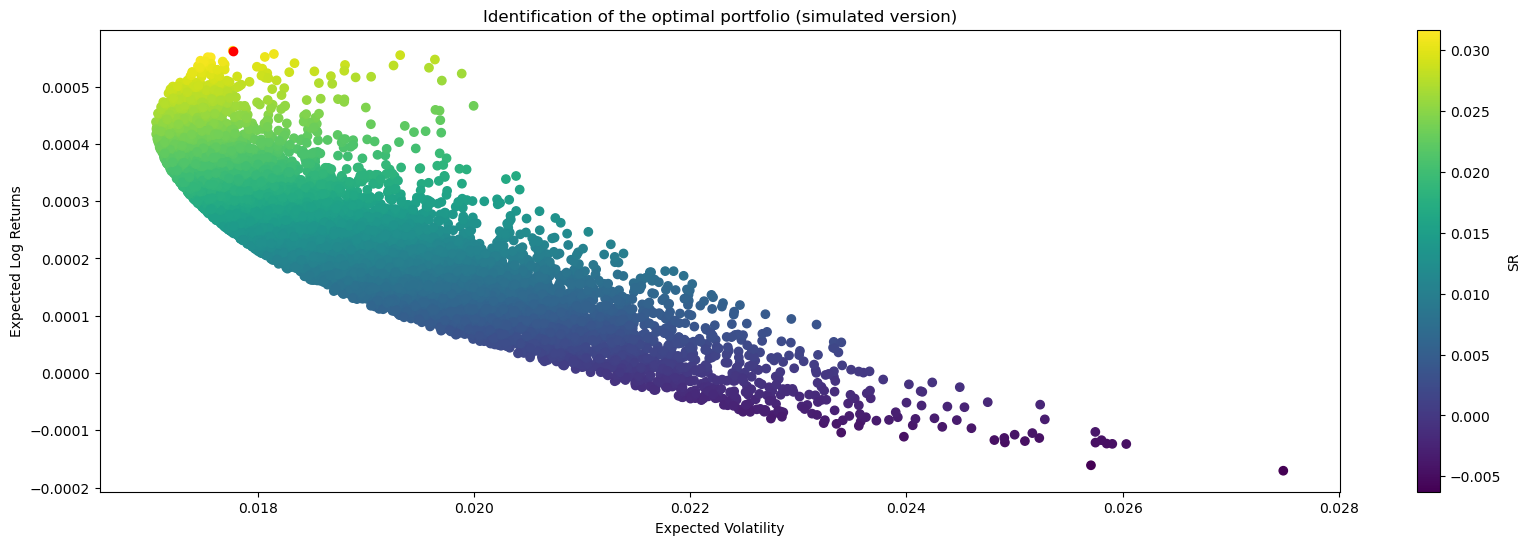

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.scatter(expectedVol,expectedLogReturn,c=sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='SR')
plt.scatter(expectedVol[maxIndex],expectedLogReturn[maxIndex],c='red')
plt.title("Identification of the optimal portfolio (simulated version)")
plt.show()

In [34]:
from scipy.optimize import minimize

# a function of weights returning negative SR function
def negativeSR(w):
    w = np.array(w)
    R = np.sum(meanLogReturn*w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    SR = R/V
    return -1*SR

# function that takes in weights and returns zero
def checkSumToOne(w):
    return np.sum(w)-1

# w0 is an "initial guess" which is equal weight for all
w0 = [0.25,0.25,0.25,0.25]
# each wi is between 0 and 1
bounds = ((0,1),(0,1),(0,1),(0,1))
# define type and a function
constraints = ({'type':'eq','fun':checkSumToOne})
w_optimal = minimize(negativeSR,w0,method='SLSQP',bounds=bounds,constraints=constraints)

In [35]:
opti_w = w_optimal.x
opti_return = sum(opti_w * meanLogReturn)
opti_vol= np.sqrt(np.dot(opti_w.T,np.dot(sigma,opti_w)))

In [36]:
minExpectedLogReturn = min(expectedLogReturn)
maxExpectedLogReturn = max(expectedLogReturn)

In [37]:
returns = np.linspace(minExpectedLogReturn,maxExpectedLogReturn,100)

v_optimal = []

# function that takes in weights and returns volatility
def minimizeVolatility(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    return V

def getReturn(w):
    w = np.array(w)
    R = np.sum(meanLogReturn*w)
    return R

for R in returns:
    # find best volatility (as we target minimal volatility we need a constraint on the returns)
    constraints = ({'type':'eq','fun':checkSumToOne},
                  {'type':'eq','fun': lambda w: getReturn(w) - R})
    opt = minimize(minimizeVolatility,w0,method='SLSQP',bounds=bounds,constraints=constraints)
    # save optimal volatility
    v_optimal.append(opt['fun'])

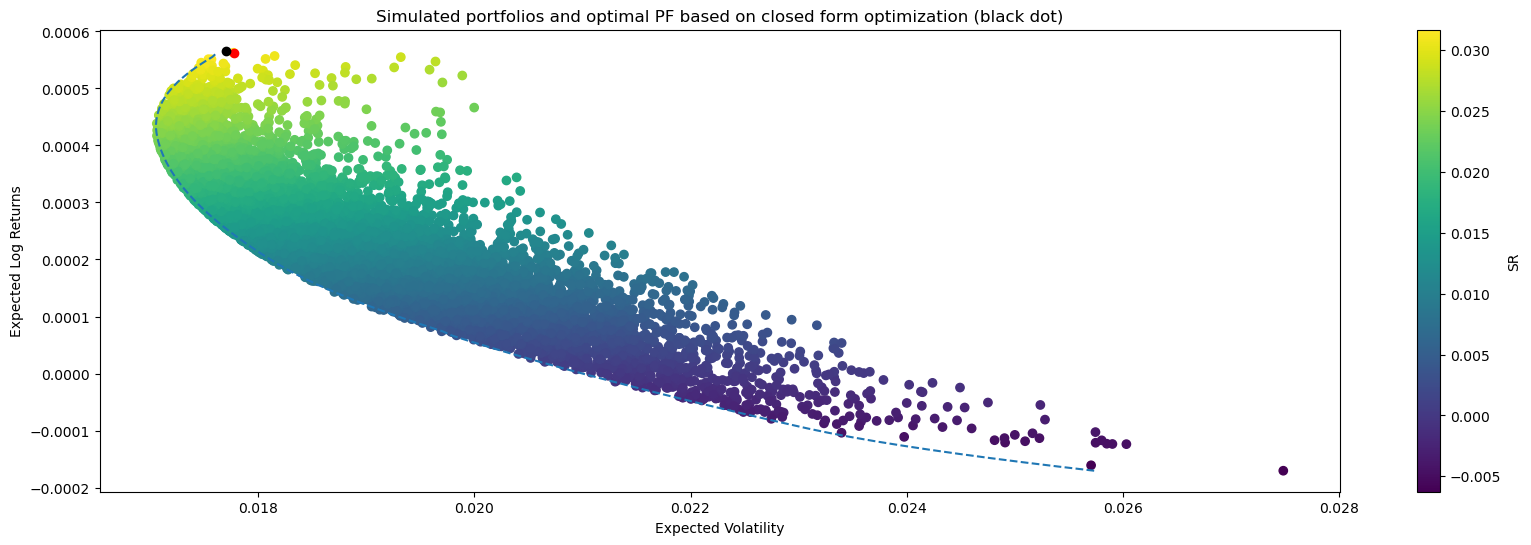

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.scatter(expectedVol,expectedLogReturn,c=sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='SR')
plt.scatter(expectedVol[maxIndex],expectedLogReturn[maxIndex],c='red')
plt.scatter(opti_vol, opti_return, c="black")
plt.plot(v_optimal,returns,'--')
plt.title("Simulated portfolios and optimal PF based on closed form optimization (black dot)")
plt.show()

In [39]:
print("The optimal weight for {} is {}%, for {} is {}%, for {} is {}% and for {} is {}%.".format(ticker1,round(opti_w[0],2)*100,ticker2,round(opti_w[1],2)*100,ticker3,round(opti_w[2],2)*100,ticker4,round(opti_w[3],2)*100))

print("According to the optimal weights you should invest {}.- in {}, {}.- in {}, {}.- in {} and {}.- isn {}.".format(round(opti_w[0]*start_capital,2),ticker1,round(opti_w[1]*start_capital,2),ticker2,round(opti_w[2]*start_capital,2),ticker3,round(opti_w[3]*start_capital,2),ticker4))

The optimal weight for meta is 0.0%, for cat is 56.00000000000001%, for amzn is 0.0% and for goog is 44.0%.
According to the optimal weights you should invest 0.0.- in meta, 1125.78.- in cat, 0.0.- in amzn and 874.22.- isn goog.


Date
2018-12-13    1.001648
2018-12-14    0.995739
2018-12-17    0.979062
2018-12-18    1.004333
2018-12-19    0.988791
                ...   
2022-12-13    1.016568
2022-12-14    0.995123
2022-12-15    0.971981
2022-12-16    1.003398
2022-12-19    0.990733
Length: 1012, dtype: float64


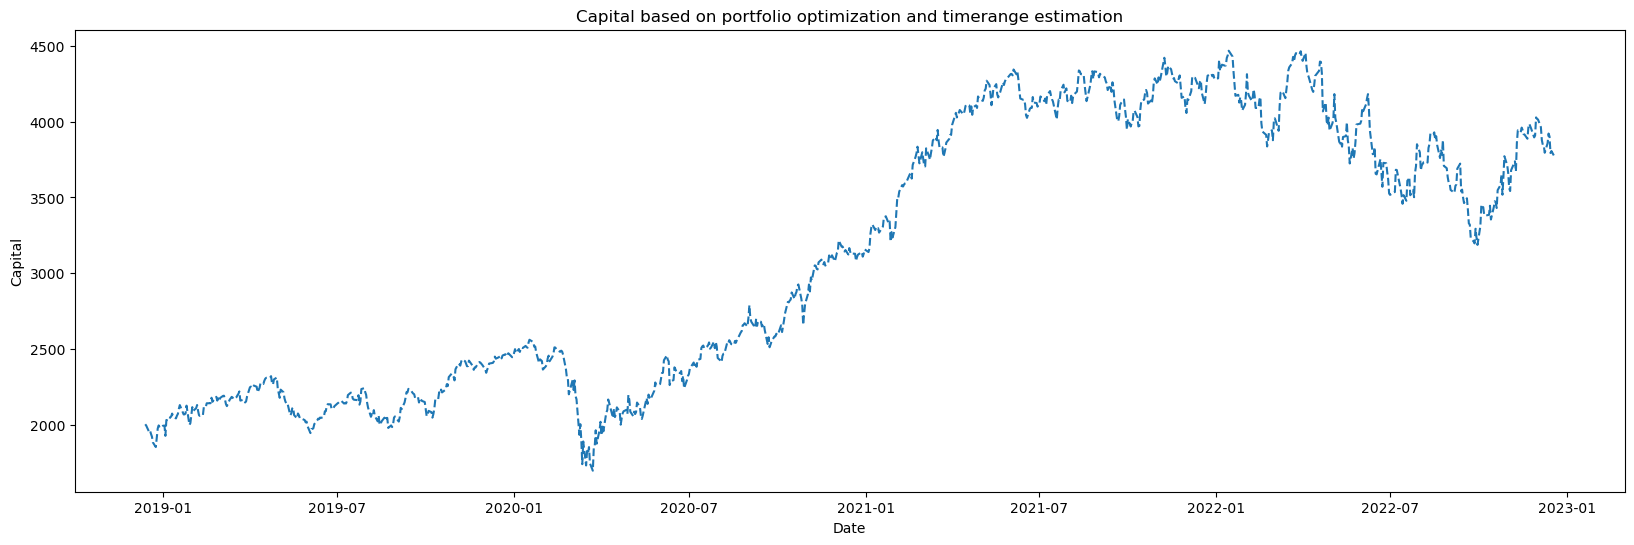

In [40]:
portfolio_returns = raw_returns.dot(opti_w.T)
portfolio_returns_factors = portfolio_returns + 1
pf_2 = portfolio_returns_factors.dropna()
print(pf_2)

port_ret_cleaned_1= pf_2.cumprod()

chart = port_ret_cleaned_1 * start_capital

plt.figure(figsize=(20,6))
plt.xlabel("Date")
plt.ylabel("Capital")
plt.plot(chart,'--')
plt.title('Capital based on portfolio optimization and timerange estimation',fontsize=12)

plt.show()